LSTM was chosen due to its ability to predict the future from sequences. Due to the nature of the feature being predicted (closing price), I felt that the LSTM model would be suitable for the task.

HOWEVER, I do not agree with this project in the following aspects:


1.   First, the closing stock price as itself is not a very useful forecast. For example, forecasting the returns on a stock might be more helpful for traders.
2.   Secondly, this particular implementation relies on data up to and including the day before any day to be predicted. This means that if I want to make a ten-day forecast non-recursively, I would require information up to 9 days in the future.
3. Lastly, due to the random walk hypothesis, the naive forecast often far outperforms any of the models generated with LSTM. Hence for the purposes of evaluation, I have chosen to submit the naive forecast (which also happens to be the forecast generated from recursive LSTM from the last part of this notebook).



In [1]:
# dataset: https://finance.yahoo.com/quote/NVDA/history?p=NVDA

In [2]:
import pandas as pd

df = pd.read_csv('NVDA.csv')

df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-10-20,121.129997,127.690002,121.050003,121.940002,121.865463,65239800
1,2022-10-21,120.980003,124.980003,118.870003,124.660004,124.583801,60949400
2,2022-10-24,125.080002,127.099998,120.639999,125.989998,125.912971,51745700
3,2022-10-25,126.940002,133.000000,126.639999,132.610001,132.528931,50548200
4,2022-10-26,128.690002,133.880005,127.080002,128.960007,128.881165,53295300
...,...,...,...,...,...,...,...
247,2023-10-16,450.630005,462.250000,449.119995,460.950012,460.950012,37509900
248,2023-10-17,440.000000,447.540009,424.799988,439.380005,439.380005,81233300
249,2023-10-18,425.910004,432.190002,418.250000,421.959991,421.959991,62729400
250,2023-10-19,428.109985,432.970001,418.820007,421.010010,421.010010,50123300


In [3]:
# fetch only the Date and Close columns
df = df[['Date', 'Close']]

df

,Date,Close
0,2022-10-20,121.940002
1,2022-10-21,124.660004
2,2022-10-24,125.989998
3,2022-10-25,132.610001
4,2022-10-26,128.960007
...,...,...
247,2023-10-16,460.950012
248,2023-10-17,439.380005
249,2023-10-18,421.959991
250,2023-10-19,421.010010


In [4]:
# convert date object into datetime64

import datetime

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

df['Date'] = df['Date'].apply(str_to_datetime)

df

<ipython-input-4-eb9c9e8e881b>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = df['Date'].apply(str_to_datetime)


,Date,Close
0,2022-10-20,121.940002
1,2022-10-21,124.660004
2,2022-10-24,125.989998
3,2022-10-25,132.610001
4,2022-10-26,128.960007
...,...,...
247,2023-10-16,460.950012
248,2023-10-17,439.380005
249,2023-10-18,421.959991
250,2023-10-19,421.010010


In [5]:
# set date as index
df.index = df.pop('Date')

df

,Close
Date,
2022-10-20,121.940002
2022-10-21,124.660004
2022-10-24,125.989998
2022-10-25,132.610001
2022-10-26,128.960007
...,...
2023-10-16,460.950012
2023-10-17,439.380005
2023-10-18,421.959991


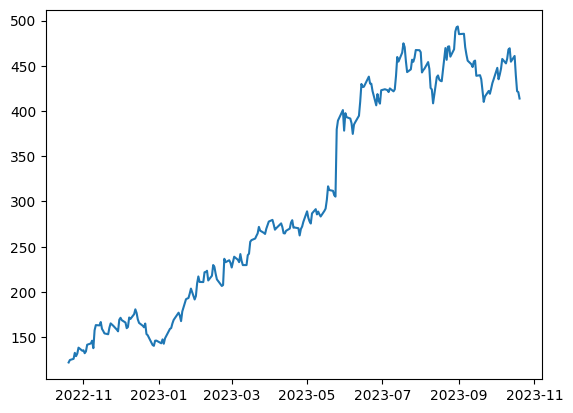

In [6]:
import matplotlib.pyplot as plt

# plot date against actual historical closing price
plt.plot(df.index, df['Close'])

In [7]:
# adds columns for each day of the sliding window into the df
def generate_sliding_window(dataframe, window=3):
  for i in range(window, 0, -1):
    dataframe[f'Target - {i}'] = dataframe['Close'].shift(i)
  return dataframe.dropna()

df = generate_sliding_window(df)

df

<ipython-input-7-49b397ced58e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[f'Target - {i}'] = dataframe['Close'].shift(i)
<ipython-input-7-49b397ced58e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[f'Target - {i}'] = dataframe['Close'].shift(i)
<ipython-input-7-49b397ced58e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

,Close,Target - 3,Target - 2,Target - 1
Date,,,,
2022-10-25,132.610001,121.940002,124.660004,125.989998
2022-10-26,128.960007,124.660004,125.989998,132.610001
2022-10-27,131.759995,125.989998,132.610001,128.960007
2022-10-28,138.339996,132.610001,128.960007,131.759995
2022-10-31,134.970001,128.960007,131.759995,138.339996
...,...,...,...,...
2023-10-16,460.950012,468.059998,469.450012,454.609985
2023-10-17,439.380005,469.450012,454.609985,460.950012
2023-10-18,421.959991,454.609985,460.950012,439.380005


In [8]:
import numpy as np

# generate the input and output
def generate_date_X_y(windowed_dataframe):
  # convert dataframe to numpy array
  df_as_np = windowed_dataframe.to_numpy()

  # fetch date column
  dates = df.index

  # fetch the inputs X
  inputs = df_as_np[:, 1:4]
  X = inputs.reshape((len(dates), inputs.shape[1], 1))

  # fetch the outputs y
  y = df_as_np[:, 0]

  return dates, X.astype(np.float32), y.astype(np.float32)

dates, X, y = generate_date_X_y(df)

dates.shape, X.shape, y.shape

((249,), (249, 3, 1), (249,))

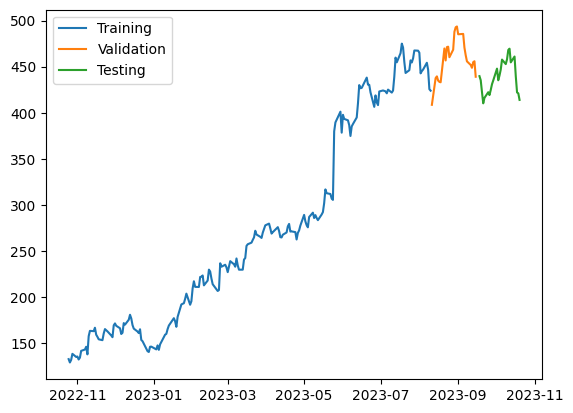

In [9]:
# generate training, validation and testing sets
q_80 = int(len(dates) * 0.8)
q_90 = int(len(dates) * 0.9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]
dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Training', 'Validation', 'Testing'])

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
7/7 [==============================] - 7s 234ms/step - loss: 84166.8125 - mean_absolute_error: 269.9012 - val_loss: 210276.9219 - val_mean_absolute_error: 458.0753
Epoch 2/100
7/7 [==============================] - 0s 24ms/step - loss: 83950.2188 - mean_absolute_error: 269.5038 - val_loss: 209908.9219 - val_mean_absolute_error: 457.6735
Epoch 3/100
7/7 [==============================] - 0s 19ms/step - loss: 83738.1016 - mean_absolute_error: 269.1104 - val_loss: 209554.4375 - val_mean_absolute_error: 457.2860
Epoch 4/100
7/7 [==============================] - 0s 25ms/step - loss: 83514.8125 - mean_absolute_error: 268.6862 - val_loss: 209085.8750 - val_mean_absolute_error: 456.7733
Epoch 5/100
7/7 [==============================] - 0s 48ms/step - loss: 83220.3750 - mean_absolute_error: 268.1461 - val_loss: 208550.9844 - val_mean_absolute_error: 456.1875
Epoch 6/100
7/7 [==============================] - 0s 27ms/step - loss: 82892.5391 - mean_absolute_error: 267.5365 - val_los

7/7 [==============================] - 1s 3ms/step


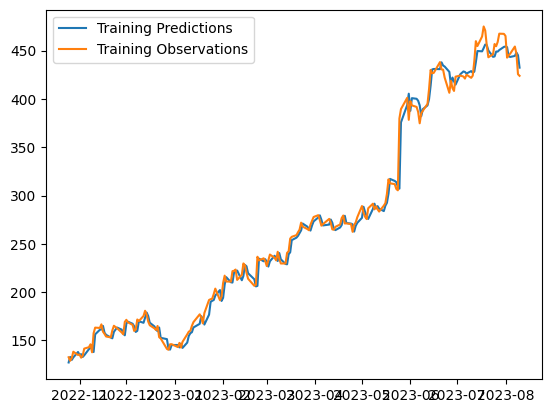

In [11]:
training_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, training_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

1/1 [==============================] - 0s 22ms/step


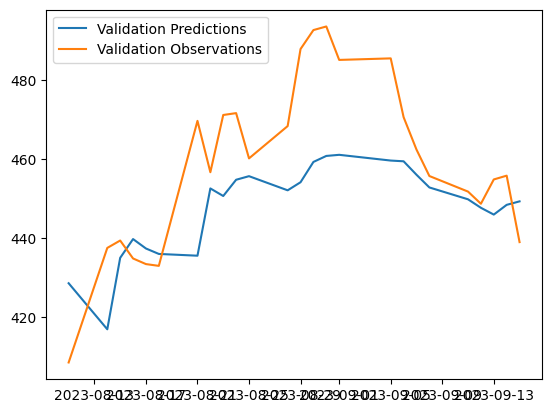

In [12]:
validation_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, validation_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

1/1 [==============================] - 0s 24ms/step


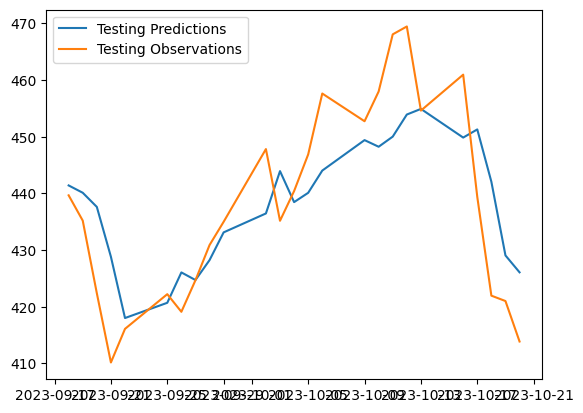

In [13]:
testing_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, testing_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [14]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

1/1 [==============================] - 0s 20ms/step


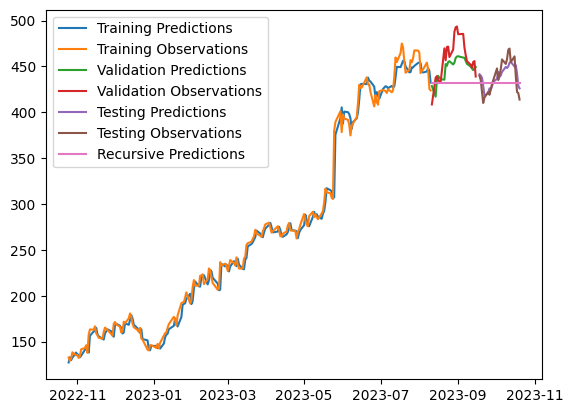

In [15]:
plt.plot(dates_train, training_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, validation_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, testing_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions', 'Training Observations', 'Validation Predictions', 'Validation Observations', 'Testing Predictions', 'Testing Observations', 'Recursive Predictions'])